In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import random
import cv2
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
import keras
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip '/gdrive/MyDrive/GSOC 2022/DEEPLENSE/TEST1/dataset.zip'

In [2]:
train_class_path = [(x+"/*") for x in glob.glob('/content/dataset/train/*')]
val_class_path = [(x+"/*") for x in glob.glob('/content/dataset/val/*')]
train_path_dict = {}
val_path_dict = {}
for i in train_class_path:
  train_path_dict[i.split('/')[-2]] = i
for i in val_class_path:
  val_path_dict[i.split('/')[-2]] = i
  
class_names= {"sphere": "Spherical Substructure", "vort":"Vortex Substructure", "no": "No Substructure"}

In [3]:
train_path_dict

{'no': '/content/dataset/train/no/*',
 'sphere': '/content/dataset/train/sphere/*',
 'vort': '/content/dataset/train/vort/*'}

In [4]:
val_path_dict

{'no': '/content/dataset/val/no/*',
 'sphere': '/content/dataset/val/sphere/*',
 'vort': '/content/dataset/val/vort/*'}

## Visualize Images

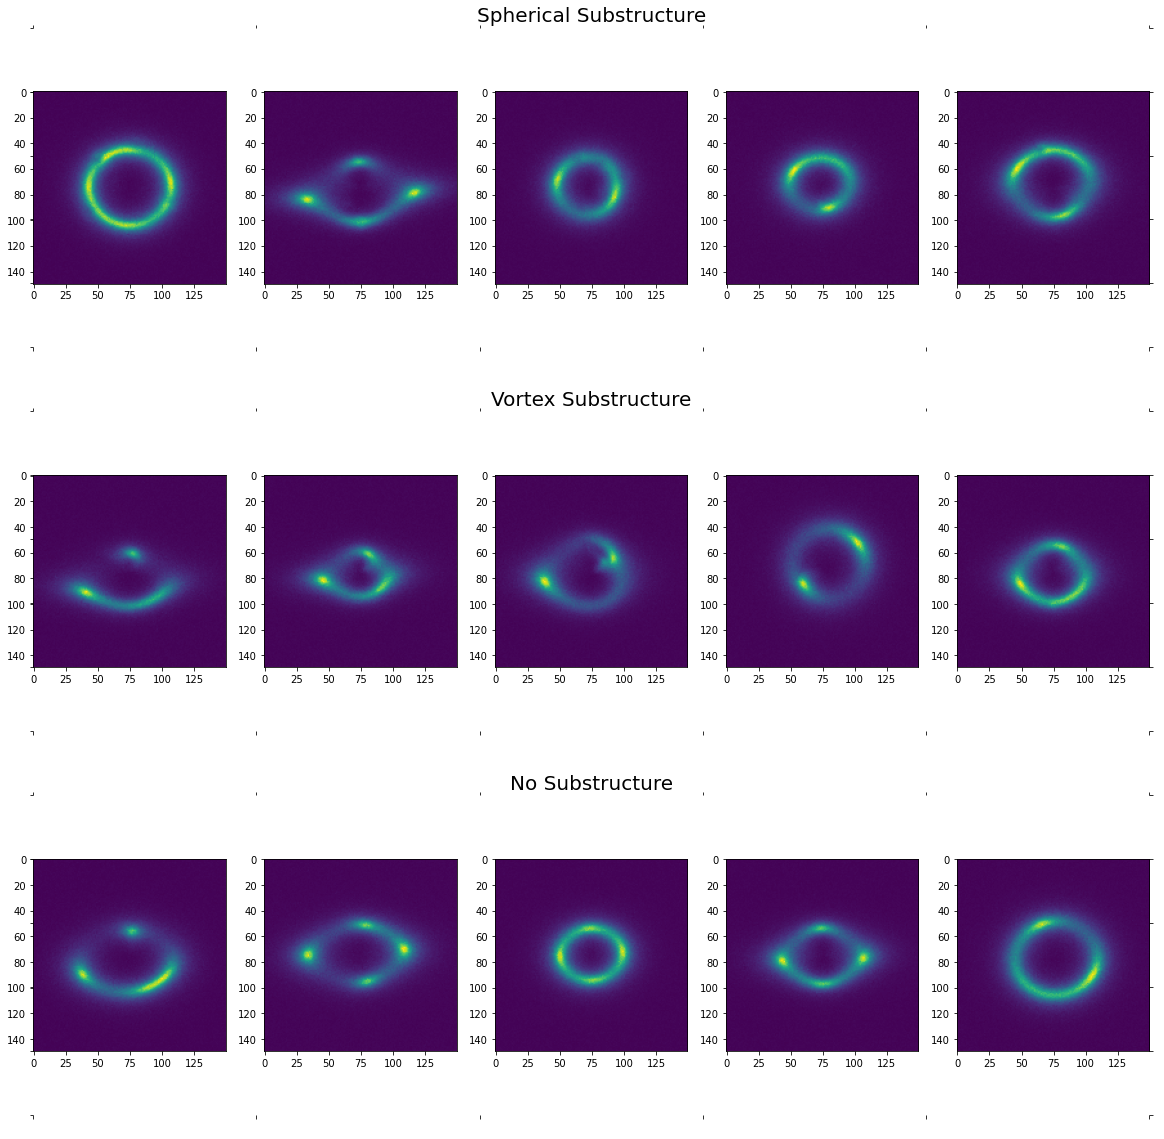

In [5]:
fig, big_axes = plt.subplots(3, 1, figsize=(20,20), sharey=True)

for big_ax, c in zip(big_axes, class_names.keys()):
    big_ax.set_title(class_names[c], fontsize=20)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False

ax = fig.subplots(3,5)
for i,j in enumerate(class_names.keys()): 
  imgs_path = random.choices(glob.glob(train_path_dict[j]), k=5)
  for k in range(len(ax[i])):
    ax[i,k].imshow(np.load(imgs_path[k])[0])
 
fig.set_facecolor('w')

### Creating Custom Data Generator

In [ ]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=100, dim=(150,150), n_channels=3,
                 n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)


        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            tmp_img = np.load(ID)[0]
            X[i,] = np.dstack((tmp_img, tmp_img, tmp_img))

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.all_utils.to_categorical(y, num_classes=self.n_classes)

### Initializing Training and Validation Generators

In [7]:
class_input_labels = {"no":0, "sphere":1, "vort":2}
class_output_labels= {0:"no", 1:"sphere", 2:"vort"}

In [8]:
all_filenames= [] 
train_list=[]
train_labels = {}
val_list = []
val_labels = {}

for i in train_path_dict:
  for j in glob.glob(train_path_dict[i]):
    all_filenames.append(j)

for i in val_path_dict:
  for j in glob.glob(val_path_dict[i]):
    all_filenames.append(j)

random.shuffle(all_filenames)

train_list, val_list = (all_filenames[0:int(0.9*len(all_filenames))], all_filenames[int(0.9*len(all_filenames)):])

for i in train_list:
  tmp_class = i.split('/')[-2]
  train_labels[i] = class_input_labels[tmp_class]

for i in val_list:
  tmp_class = i.split('/')[-2]
  val_labels[i] = class_input_labels[tmp_class]

### Training and Validation Set Description


In [9]:
print("No of Training images:-",len(train_list))
print("No of Validation images:-",len(val_list))
print("Shape of Training images:-", np.load(train_list[0]).shape)
print("Shape of Validation images:-", np.load(val_list[0]).shape)

No of Training images:- 33750
No of Validation images:- 3750
Shape of Training images:- (1, 150, 150)
Shape of Validation images:- (1, 150, 150)


### Initializing Training and Validation Generators

In [ ]:
params = {'dim': (150,150),
          'batch_size': 100,
          'n_classes': 3,
          'n_channels': 3,
          'shuffle': True}

training_generator = DataGenerator(train_list, train_labels, **params)
validation_generator = DataGenerator(val_list, val_labels, **params)

### Visualizing training data and labels

2
Class of Image:- Vortex Substructure



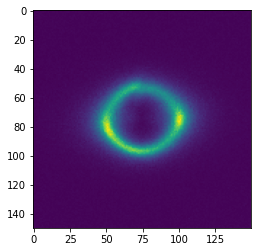

In [ ]:
rand_ind = random.randint(0,len(train_list)-1)
print(train_labels[train_list[rand_ind]])
print("Class of Image:-",class_names[class_output_labels[train_labels[train_list[rand_ind]]]])
print()
plt.imshow(np.load(train_list[rand_ind])[0])

## VGG16 with modified top layers

In [ ]:
model = Sequential()

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False

flatten_layer = Flatten()
dense_layer_1 = Dense(50, activation='relu')
dense_layer_2 = Dense(20, activation='relu')
prediction_layer = Dense(3, activation='softmax')


model = Sequential([base_model, flatten_layer, dense_layer_1, dense_layer_2, prediction_layer])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_27 (Dense)            (None, 50)                409650    
                                                                 
 dense_28 (Dense)            (None, 20)                1020      
                                                                 
 dense_29 (Dense)            (None, 3)                 63        
                                                                 
Total params: 15,125,421
Trainable params: 410,733
Non-trainable params: 14,714,688
_________________________________________________________________


### Training model and VIsualizing Results

In [ ]:
history = model.fit_generator(generator=training_generator,  validation_data=validation_generator, epochs=50)


Epoch 1/50
337/337 [==============================] - 176s 521ms/step - loss: 0.9473 - accuracy: 0.5169 - val_loss: 0.9910 - val_accuracy: 0.4830
Epoch 2/50
337/337 [==============================] - 176s 521ms/step - loss: 0.9483 - accuracy: 0.5190 - val_loss: 0.9618 - val_accuracy: 0.5062
Epoch 3/50
337/337 [==============================] - 175s 520ms/step - loss: 0.9416 - accuracy: 0.5231 - val_loss: 0.9603 - val_accuracy: 0.5035
Epoch 4/50
337/337 [==============================] - 175s 520ms/step - loss: 0.9382 - accuracy: 0.5240 - val_loss: 0.9641 - val_accuracy: 0.4959
Epoch 5/50
337/337 [==============================] - 175s 520ms/step - loss: 0.9290 - accuracy: 0.5326 - val_loss: 0.9520 - val_accuracy: 0.5184
Epoch 6/50
337/337 [==============================] - 175s 519ms/step - loss: 0.9343 - accuracy: 0.5315 - val_loss: 1.0494 - val_accuracy: 0.4465
Epoch 7/50
337/337 [==============================] - 175s 519ms/step - loss: 0.9296 - accuracy: 0.5318 - val_loss: 0.9454 -

#### It can be seen that after 50 epopchs the Validation Accuracy is only 54.16 percent.

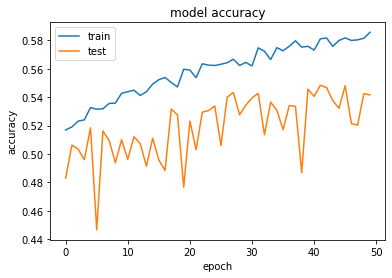

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

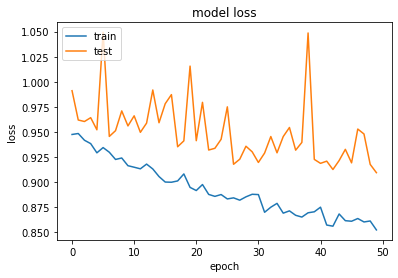

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Due to the poor performance of generally used architectures, an Equivarient CNN architecture is used.  

---







## General E(2)-Equivariant Steerable CNNs

In [11]:
!pip install e2cnn

     |████████████████████████████████| 224 kB 5.0 MB/s 


In [10]:
import torch
import torchvision

from e2cnn import gspaces
from e2cnn import nn

from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import torchvision.transforms as transforms

import numpy as np

from PIL import Image

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=3):
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=8)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 129, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = nn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(43264, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

### Initialize the model

In [12]:
model = C8SteerableCNN().to(device)

### Custom Lens Dataloader

In [13]:
class LensDatasetLoader(Dataset):
    
    def __init__(self, path_list, label_list, transform=None):

        self.transform = transform
        self.images = path_list
        self.labels = label_list
        self.num_samples = len(self.labels)
    
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[self.images[index]]
        tmp_img = np.load(image)[0]
        tmp_img2 = np.dstack((tmp_img, tmp_img, tmp_img))
        image = Image.fromarray((tmp_img2*255).astype(np.uint8))
        if self.transform is not None:
            image = self.transform(image)
        return image, to_categorical(label, num_classes = 3)
    
    def __len__(self):
        return len(self.images)


In [16]:
# images are padded to have shape 129x129.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)

totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [17]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    resize1,
    RandomRotation(180, resample=Image.BILINEAR, expand=False),
    resize2,
    totensor,
    togray,
])
transform_val = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    totensor,
    togray,
   
])
trainset = LensDatasetLoader(path_list = train_list, label_list = train_labels, transform=transform_train)
valset = LensDatasetLoader(path_list = val_list, label_list = val_labels, transform=transform_val)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64)

loss_function = torch.nn.CrossEntropyLoss()
#loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [18]:
log_interval = 100
for epoch in range(15):
    model.train()
    for i, (x, t) in enumerate(train_loader):        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)
        loss = loss_function(y, t)
        if i % log_interval == 0:
            print('Loss: ',loss.item())
        loss.backward()

        optimizer.step()
    
    if epoch % 1 == 0:
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for i, (x, t) in enumerate(val_loader):
                x = x.to(device)
                t = t.to(device)
                y = model(x)
                #y_pred = y.flatten().to(torch.float64)
                

                _, prediction = torch.max(y.data, 1)
                _, t = torch.max(t.data, 1)
                #prediction = (y_pred > 0.5).to(torch.int64)
                total += t.shape[0]
                correct += (prediction == t).sum().item()
        print(f"epoch {epoch} | test accuracy: {correct/total*100.}")

Loss:  1.1827396154403687
Loss:  1.0891261100769043
Loss:  1.092308759689331
Loss:  1.103841781616211
Loss:  1.1177958250045776
Loss:  1.0956778526306152
epoch 0 | test accuracy: 34.56
Loss:  1.0765087604522705
Loss:  1.0189995765686035
Loss:  0.9118912220001221
Loss:  0.7461422681808472
Loss:  0.7659891843795776
Loss:  0.7759526968002319
epoch 1 | test accuracy: 37.946666666666665
Loss:  0.6169567704200745
Loss:  0.4622095227241516
Loss:  0.5225237607955933
Loss:  0.44653213024139404
Loss:  0.3153786063194275
Loss:  0.4752694070339203
epoch 2 | test accuracy: 70.64
Loss:  0.4071277976036072
Loss:  0.3273337781429291
Loss:  0.5162792205810547
Loss:  0.30317363142967224
Loss:  0.5402872562408447
Loss:  0.32863348722457886
epoch 3 | test accuracy: 78.4
Loss:  0.31830644607543945
Loss:  0.3421865701675415
Loss:  0.3520277738571167
Loss:  0.41939008235931396
Loss:  0.15984316170215607
Loss:  0.47425952553749084
epoch 4 | test accuracy: 90.05333333333333
Loss:  0.38952499628067017
Loss:  0.

In [19]:
torch.save(model.state_dict(), '/gdrive/MyDrive/GSOC 2022/DEEPLENSE/TEST1/model_15_epochs.pth')

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from itertools import cycle
val_loader = torch.utils.data.DataLoader(valset, batch_size=64)

with torch.no_grad():

    model.eval()
    t_t = []
    y_t = []
    for i, (x, t) in enumerate(val_loader):
        x = x.to(device)
        t = t.to(device)
        y = model(x)


        
        _, prediction = torch.max(y.data, 1)
        _, t = torch.max(t.data, 1)
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        
        t_t.append(t.cpu().numpy())
        y_t.append(y.cpu().detach().numpy())
        
    print(f"epoch {epoch} | test accuracy: {correct/total*100.}")

epoch 14 | test accuracy: 91.94666666666666


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.936


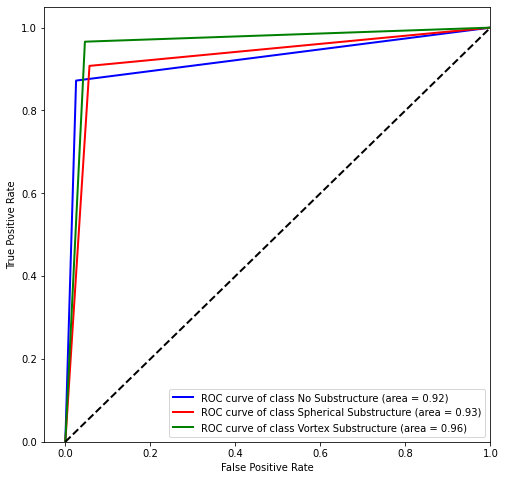

In [25]:
t_ttr = []
y_ttr = []
for tt in t_t:
  for gh in tt:
      t_ttr.append(gh)
        
for yy in y_t:
    for hg in yy:
        y_ttr.append(np.argmax(hg))
              

ns_probs = [0 for _ in range(len(np.asarray(t_ttr)))]

ns_auc = roc_auc_score(np.asarray(t_ttr), to_categorical(ns_probs,num_classes=3), multi_class = "ovr")

lr_auc = roc_auc_score(np.asarray(t_ttr),to_categorical(y_ttr,num_classes=3), multi_class = "ovr")
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
f= plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
for i in range(n_classes):
  y_true = to_categorical(t_ttr,num_classes=3)[:,i]
  y_score = to_categorical(y_ttr,num_classes=3)[:,i]
  fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
  roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[class_output_labels[i]], roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()